# Hierarchical clustering Effects/Medicals/Flavours only

https://scikit-learn.org/stable/modules/clustering.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_tight.csv')

In [3]:
df_mr = pd.read_csv('data/df_mr.csv')

Let's analyze our data under hierarchical clusters. We'll start with a dendrogram visualizing the clusters for our numerical data. We'll start with method='ward', metric='euclidean' (the only possible metric for ward.

In [4]:
# EFFECTS, FLAVOURS, AND MEDICALS ONLY!

# Drop all non-numerical data
X = df.drop(['Strain', 'Strain_type', 'Rating_scaled', 'Num_reviews_scaled',\
             'Lean', 'THC_scaled'], axis=1)
X.columns

Index(['Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical', 'Pungent', 'Flowery',
       'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus', 'Diesel', 'Lemon_Lime',
       'Appearment', 'Grape', 'Skunk', 'Eff_Focused', 'Med_Inflammation',
       'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes', 'Med_Lack_of_appetite',
       'Eff_Happy', 'Eff_Creative', 'Med_Muscle_spasms', 'Eff_Sleepy',
       'Med_Stress', 'Eff_Tingly', 'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea',
       'Med_Fatigue', 'Med_Cramps', 'Eff_Uplifted', 'Eff_Headache',
       'Eff_Talkative', 'Eff_Paranoid', 'Eff_Hungry', 'Eff_Giggly',
       'Med_Depression', 'Eff_Relaxed', 'Med_Pain', 'Eff_Euphoric',
       'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches', 'Med_Insomnia',
       'Apricot_Grapefruit'],
      dtype='object')

We'll use all our rows (no train_test_split) since we're classifying, not predicting, our data.

### Graph: Scipy: dendrogram

Below we'll study our dendrograms using sklearn. For now, we'll use scipy, since only scipy can be used to visaulize a dendrogram.

Our first dendrogram will use the ward method (euclidean affinity).

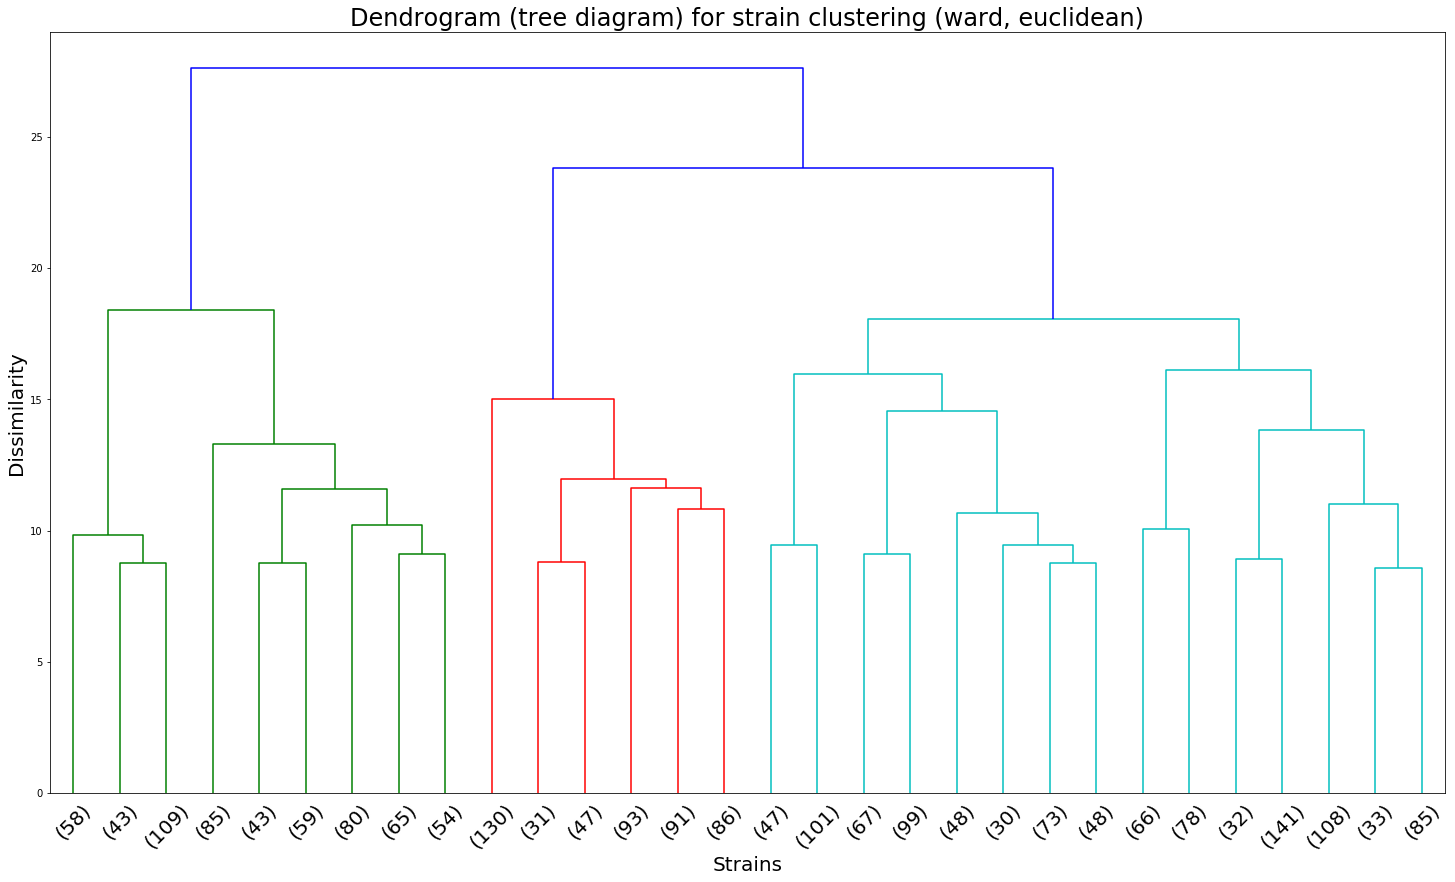

In [5]:
# Dendrogram clustering for ward, euclidean
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
# dendrogram(linky, leaf_rotation=90, leaf_font_size=0) # full dendrogram
dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
plt.title('Dendrogram (tree diagram) for strain clustering (ward, euclidean)', fontsize=24)
plt.xlabel('Strains', fontsize=20)
plt.ylabel('Dissimilarity', fontsize=20)
plt.show();

It looks like we've got 2, possibly 3, main groups, with 6 possible subgroups in total. Below, we'll explore the features of these 2, 3, 4, and 6 groups to better identify their distinctive characteristics.

### Explore effect, medical, and flavours for k=2, 3, 4, and 6

Let's get a column for each of our desired clusterings and append the clustering values to X. We can explore clusterings for each value of k in turn.

In [6]:
# Cluster and add columns for k = 2, 3, 4, 6
k_list = [2,3,4,6]
for k in k_list:
    clusters = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    clusters.fit(X)
    X[f'cluster_{k}']=clusters.labels_ # assign the cluster labels to our dataframe
    
X.columns

Index(['Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical', 'Pungent', 'Flowery',
       'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus', 'Diesel', 'Lemon_Lime',
       'Appearment', 'Grape', 'Skunk', 'Eff_Focused', 'Med_Inflammation',
       'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes', 'Med_Lack_of_appetite',
       'Eff_Happy', 'Eff_Creative', 'Med_Muscle_spasms', 'Eff_Sleepy',
       'Med_Stress', 'Eff_Tingly', 'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea',
       'Med_Fatigue', 'Med_Cramps', 'Eff_Uplifted', 'Eff_Headache',
       'Eff_Talkative', 'Eff_Paranoid', 'Eff_Hungry', 'Eff_Giggly',
       'Med_Depression', 'Eff_Relaxed', 'Med_Pain', 'Eff_Euphoric',
       'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches', 'Med_Insomnia',
       'Apricot_Grapefruit', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_6'],
      dtype='object')

In [7]:
# # RESET X !!!
# X = df.drop(['Strain', 'Strain_type', 'Rating_scaled', 'Num_reviews_scaled',\
#              'Lean', 'THC_scaled'], axis=1)

X how has columns labelling clusters for k = 2, 3, and 6. For each of these values we'll explore two things:

1. The standard deviation of each cluster's features - this will tell us how diffuse the values of feature are within each cluster.

2. The standard deviation (or difference) of feature's average values across all clusters feature. By computing the mean of each cluster's features, we can see how far apart they are from each other and select that cluster's most salient aspects.

### Define functions

To compare clusters, we need to aggregate our rows these rows by cluster number. When we group by cluster number we'll take the means of our dataframe's numeric values and treat those as our clusters' average values.

In [8]:
X.columns

Index(['Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical', 'Pungent', 'Flowery',
       'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus', 'Diesel', 'Lemon_Lime',
       'Appearment', 'Grape', 'Skunk', 'Eff_Focused', 'Med_Inflammation',
       'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes', 'Med_Lack_of_appetite',
       'Eff_Happy', 'Eff_Creative', 'Med_Muscle_spasms', 'Eff_Sleepy',
       'Med_Stress', 'Eff_Tingly', 'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea',
       'Med_Fatigue', 'Med_Cramps', 'Eff_Uplifted', 'Eff_Headache',
       'Eff_Talkative', 'Eff_Paranoid', 'Eff_Hungry', 'Eff_Giggly',
       'Med_Depression', 'Eff_Relaxed', 'Med_Pain', 'Eff_Euphoric',
       'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches', 'Med_Insomnia',
       'Apricot_Grapefruit', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_6'],
      dtype='object')

In [9]:
def make_df_c_stds(k):
    # DROP IRRELEVANT K-COLUMNS
    df_c = X.copy()
    k_list = [2,3,4,6]
    for i in k_list:
        if k != i:
            df_c.drop(f'cluster_{i}', axis=1, inplace=True)
        
    # CREATE df_stds, AN INTRA-CLUSTER STD DATAFRAME FOR EACH CLUSTER SIZE
    df_stds = pd.DataFrame()
    for i in range(0,k):
        df_cut = df_c[df_c[f'cluster_{k}'] == i]
        std = np.std(df_cut)
        df_stds = df_stds.append(std, ignore_index=True)
    df_stds = df_stds.drop(f'cluster_{k}', axis=1)
    
    return df_c, df_stds

In [10]:
def intra_heatmap(k):
    # CREATE AND SAVE A HEATMAP OF INTRA-CLUSTER STD
    plt.figure(figsize=(16,4))
    figure = sns.heatmap(df_stds, vmin=0.1, vmax=0.35, square=True)
    plt.title(f'Heatmap of feature standard deviations for {k} clusters')
    plt.show();
    figure.figure.savefig(f'graphs/intra_cluster_stds_{k}')
    
    return None

In [11]:
def make_df_avg_std(k, df_c):
    # CREATE df_avg_std OF FEATURE AVERAGES SORTED BY CLUSTER
    # *** LAST ROW IS INTER-CLUSTER STD OF THE AVERAGES ***
    
    df_avg = pd.DataFrame()
    for i in range(0,k):    
        df_cut = df_c[df_c[f'cluster_{k}'] == i]
        df_temp = df_cut.agg("mean", axis="rows")
        df_avg[i] = df_temp
    df_avg = df_avg.T
    df_avg.drop(f'cluster_{k}', axis=1, inplace=True) # Drop the "cluster" column
    
    # CREATE INTER-CLUSTER STD
    std = np.std(df_avg)
    std.name = "std"
    df_avg_std = df_avg.append(std.T, ignore_index=True)
    
    return df_avg_std

In [12]:
def feature_bars(k, df_avg_std):
    # CREATE AND SAVE A BART CHART OF INTER-CLUSTER STD
    cluster_stds = df_avg_std.iloc[k].sort_values(ascending=False)
    
    plt.figure(figsize=(10,12))
    figure = sns.barplot(y=cluster_stds.index, x=cluster_stds.values)
    plt.xlabel('Cluster feature standard deviations')
    plt.xlim((0,0.3))
    plt.title(f'Cluster feature standard deviations for {k} clusters)')
    plt.show();
    figure.figure.savefig(f'graphs/inter_cluster_stds_{k}')
    
    # CREATE AND SAVE BAR CHARTS OF FEATURE AVERAGES FOR EACH CLUSTER
    for i in range (0,k):
        plt.figure(figsize=(10,10))
        figure = sns.barplot(y=df_avg_std.columns,\
                             x=df_avg_std.iloc[i].values)
        plt.xlabel('Values')
        plt.xlim(0,1)
        plt.title(f'Feature averages: cluster {i+1} of {k}')
        plt.show();
        figure.figure.savefig(f'graphs/features_{i+1}_of_{k}')
    
    return cluster_stds

### Analysis of ward clustering, k=3

Let's start with k=3.

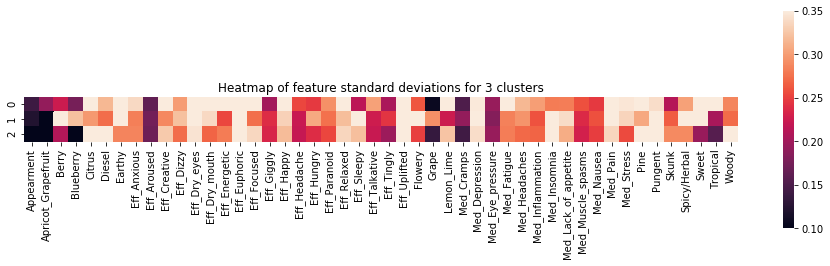

In [13]:
k=3
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)

As expected given our previous analysis some of the low-column, "noisy" columns like Appearment, Apricot-Grapefruit, Eff_Aroused, Med_Cramps, and Med_Eye_pressure have a fairly similar std. We'll undoubtedly eliminate those later on.

More relevant the division of berry/blueberry, Sleepy, Lemon-Lime, Skunk, Sweet, and Tropical.  Also Creative, Tropical, Fatigue, Spicy/Herbal, and Woody.

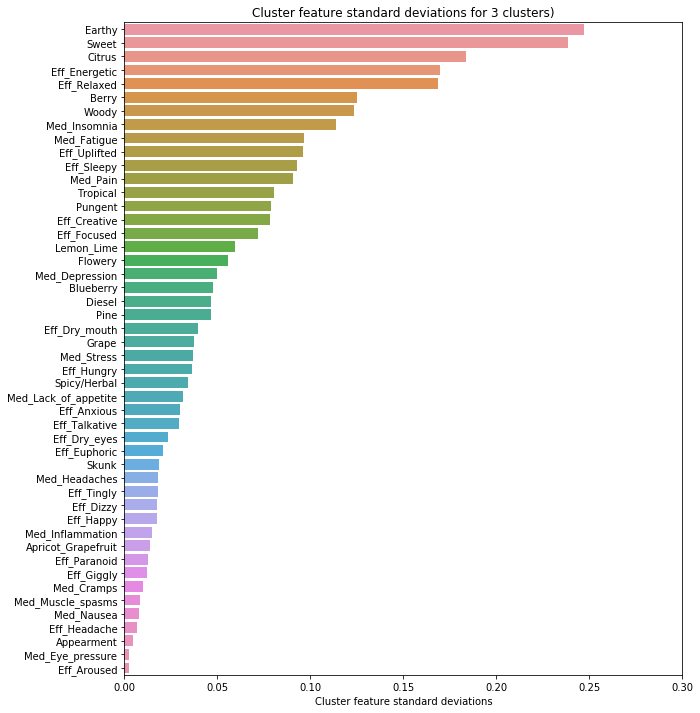

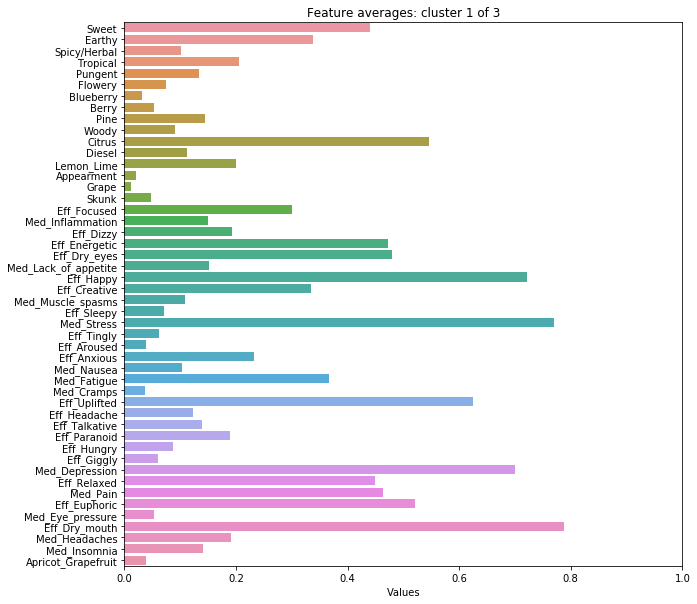

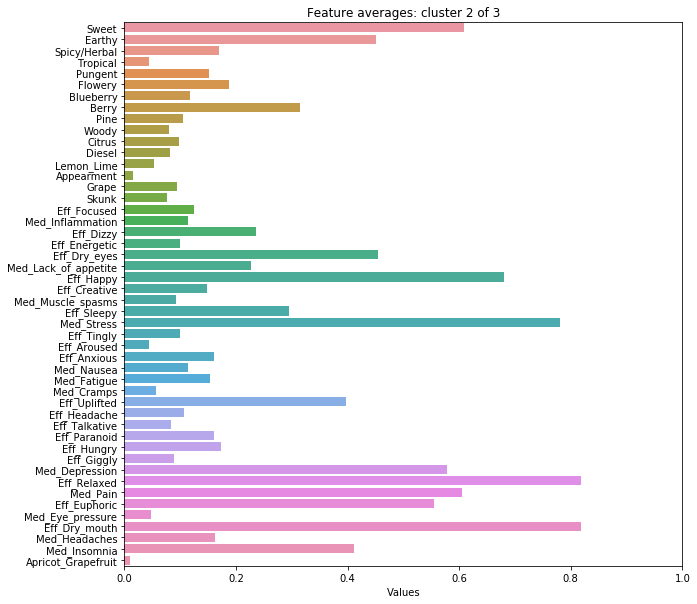

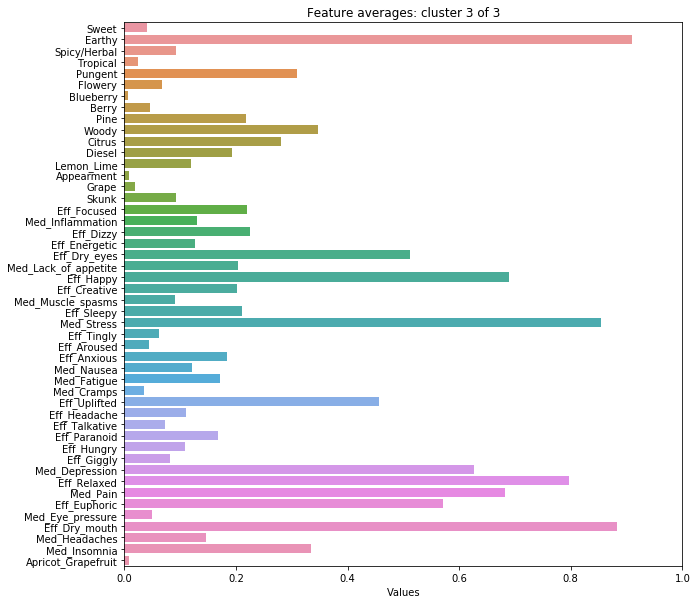

In [14]:
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)

Out of our total 48 features, let's select all the features whose standard deviations are over 0.05. We'll do that for all our k-values and assess these series collecively to identify the features we'll retain in our best model.

In [15]:
useful_features_3 = cluster_stds[cluster_stds > 0.05]
len(useful_features_3)

18

### Analysis of ward clustering, k=2

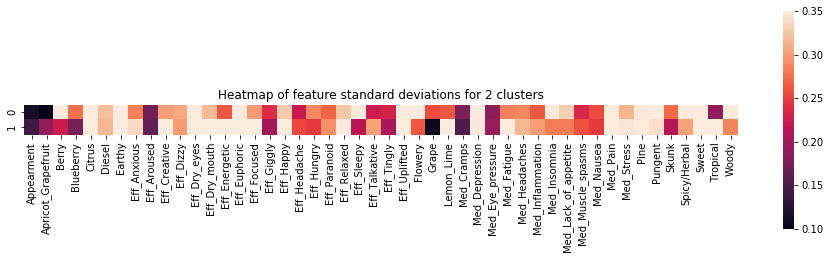

In [16]:
k=2
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)

For k=2 one group has a lower variance for Berry/Blueberry, Eff_Giggly, Eff_Sleepy, Grape, Floewery, Skunk, and Woody. The other: Eff_Anxious, Eff_Energetic, Eff_Talkative, Eff_Fatigue, and Tropical.

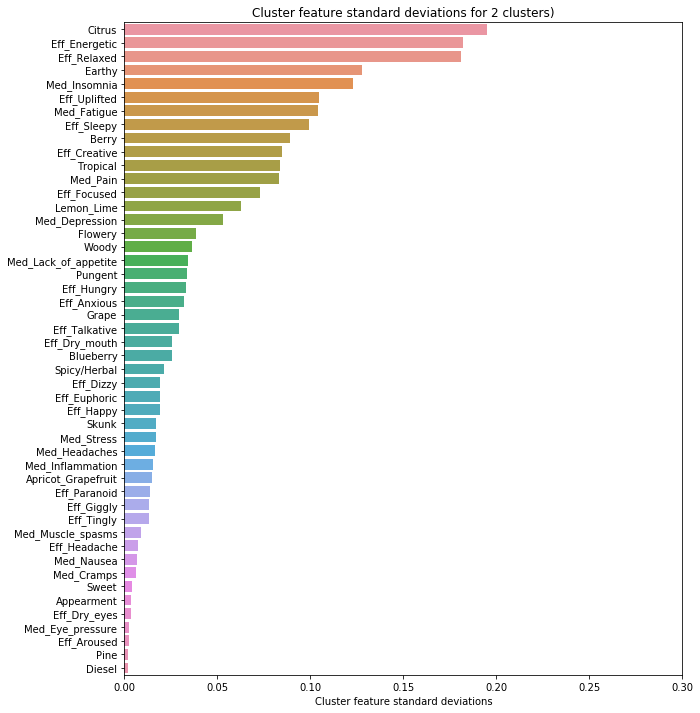

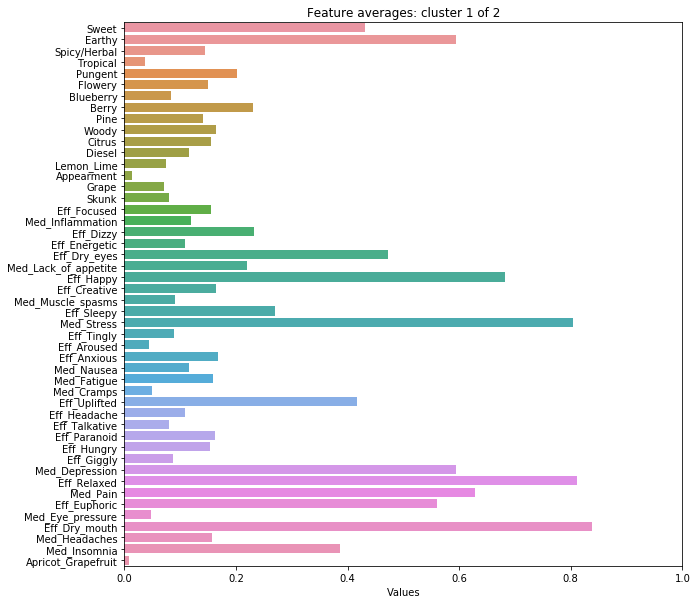

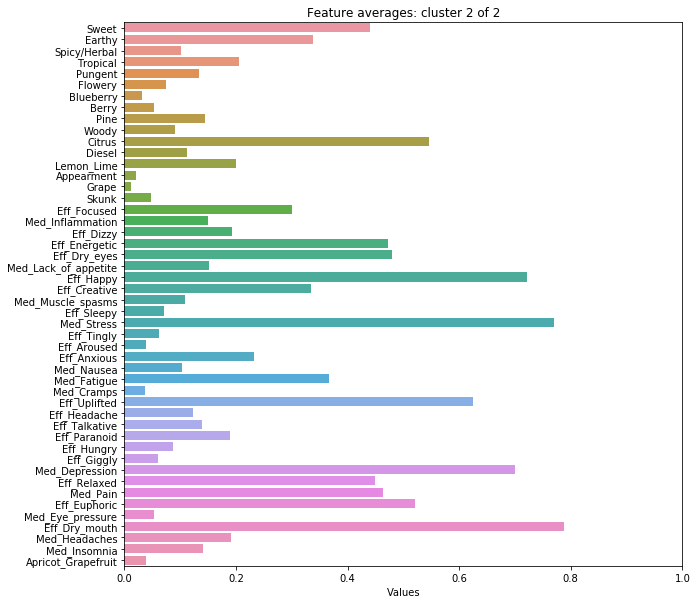

In [17]:
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)

These two clusters have closer Sweet/Earthy values and vary more along Sleepy/Energetic, Citrus/Berry.

In [18]:
useful_features_2 = cluster_stds[cluster_stds > 0.05]
len(useful_features_2)

15

### Analysis of ward clustering, k=4, 6

We'll run our functions for k = 4 and 6 subsequently. I won't be commenting on their results in this notebook - I'll save my thoughts for after we've determine our most useful features.

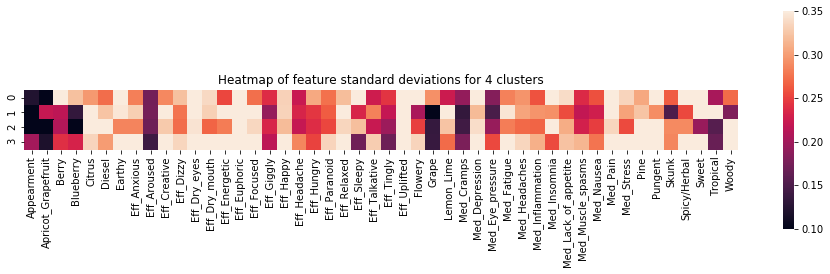

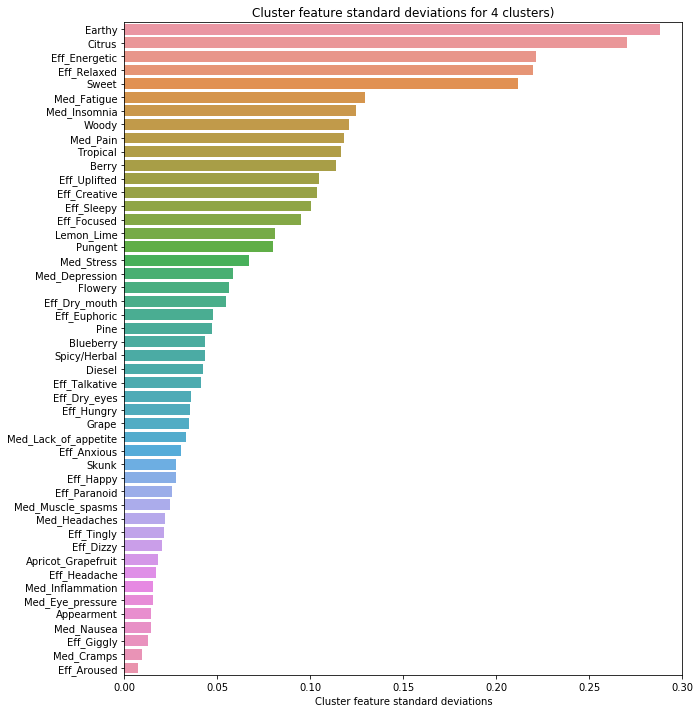

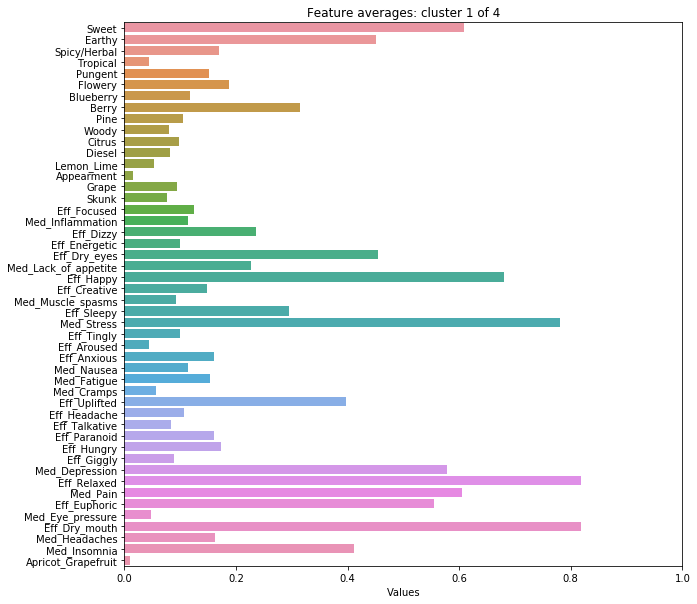

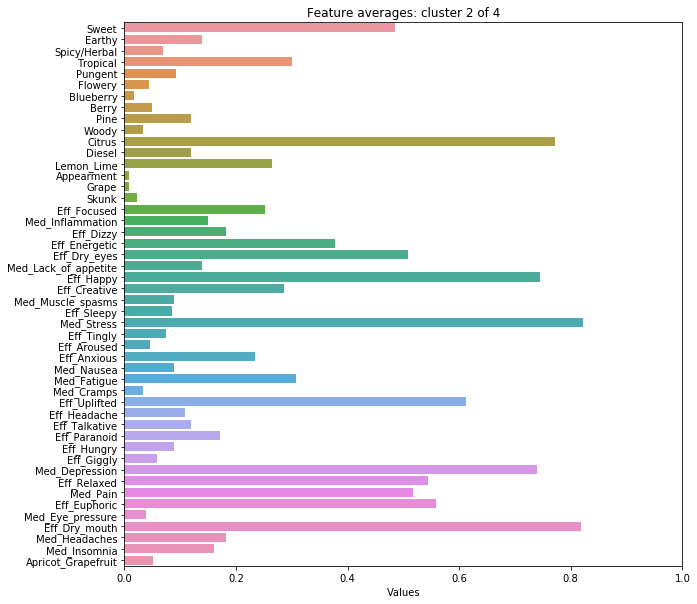

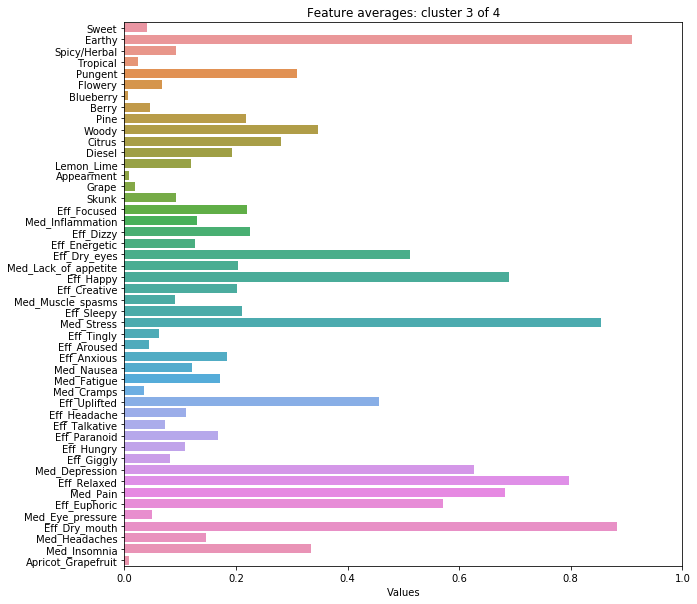

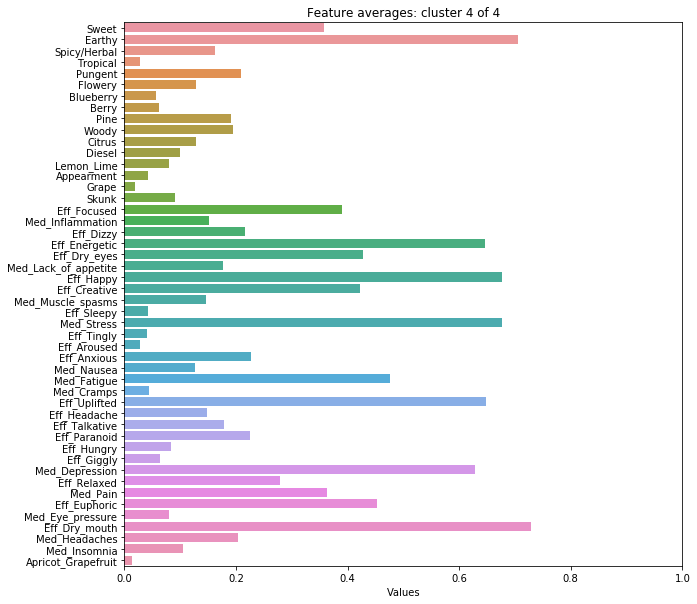

21

In [19]:
k=4
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)
useful_features_4 = cluster_stds[cluster_stds > 0.05]
len(useful_features_4)

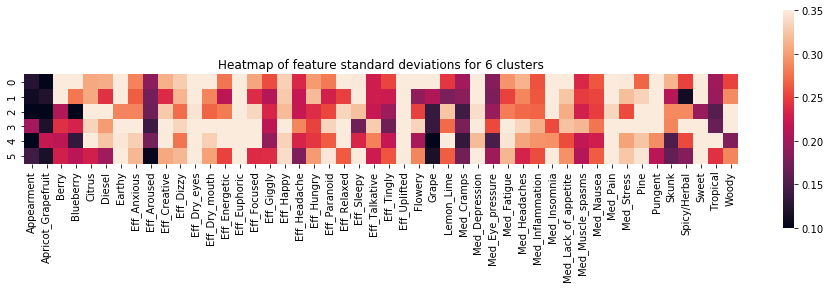

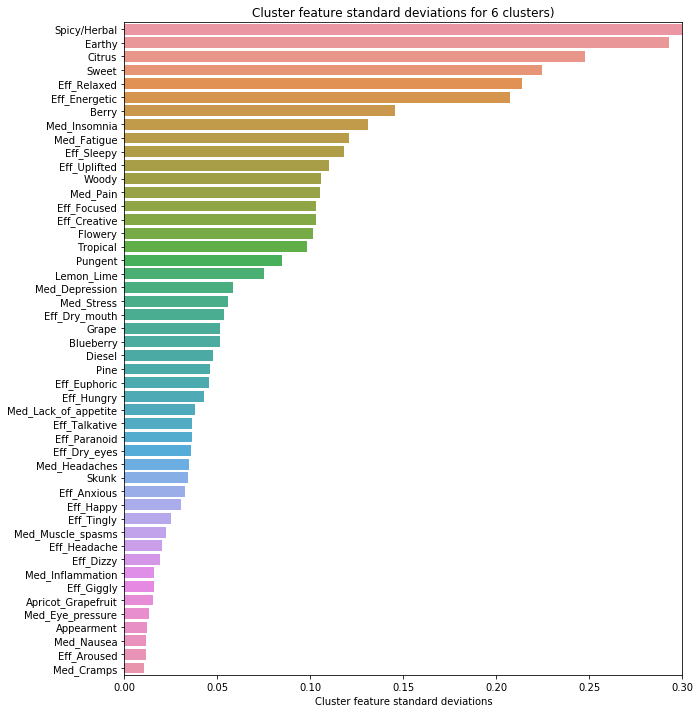

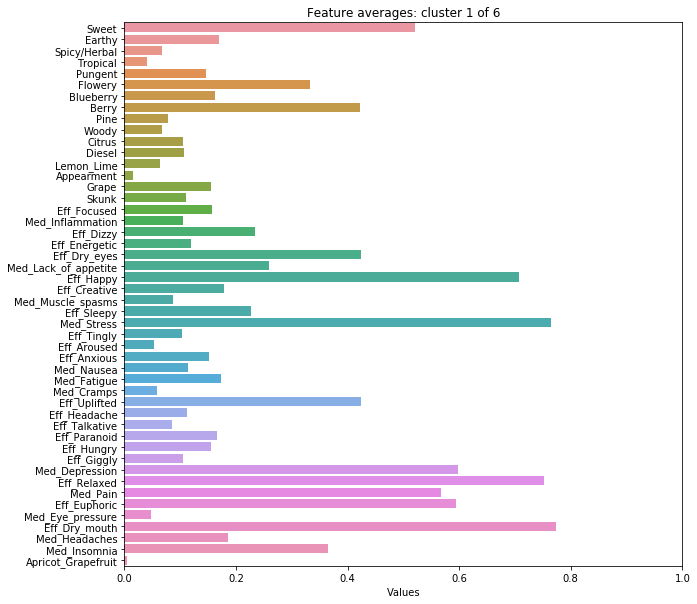

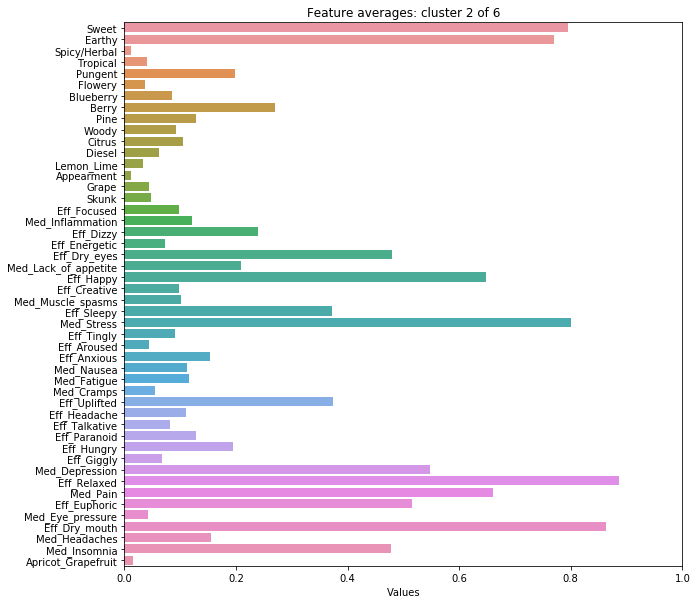

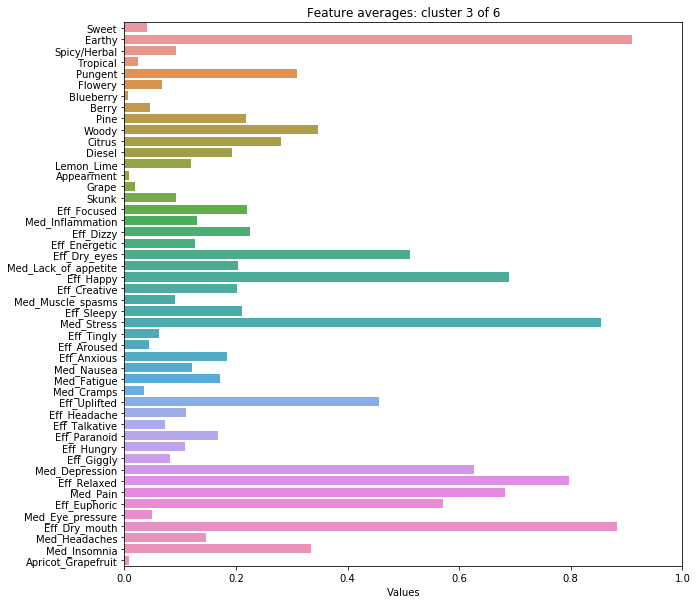

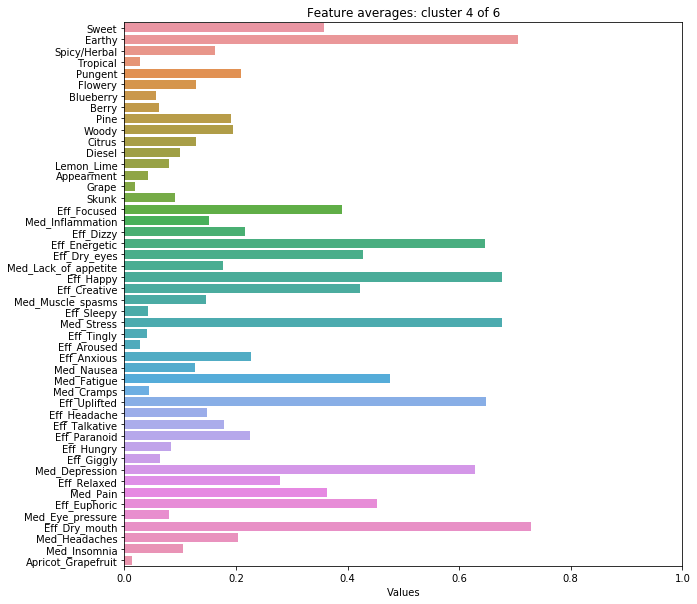

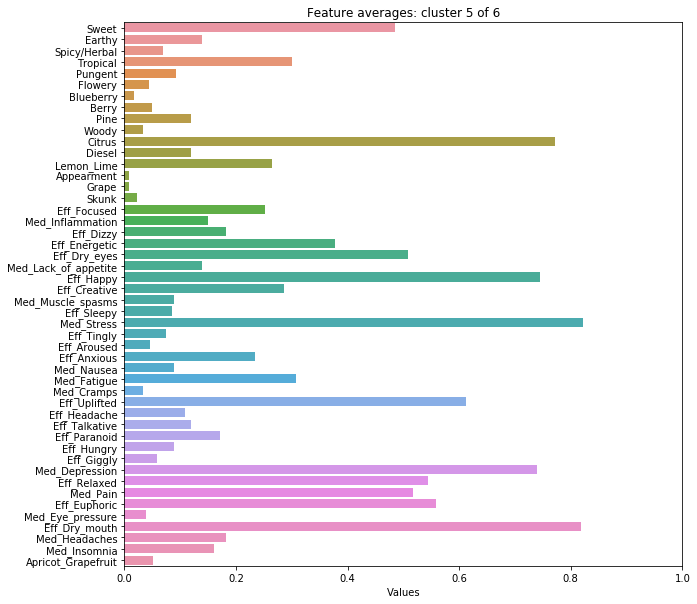

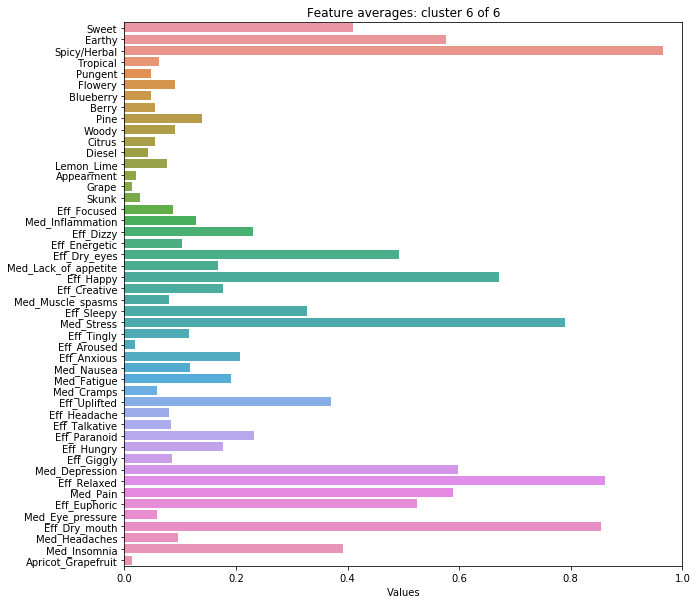

24

In [20]:
k=6
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)
useful_features_6 = cluster_stds[cluster_stds > 0.05]
len(useful_features_6)

### Best model feature selection

For our best model, we'll begin by only considering these features (which can be further reduced).

In [21]:
print(len(useful_features_2))
print(len(useful_features_3))
print(len(useful_features_4))
print(len(useful_features_6))

15
18
21
24


At this point we have four possible sets of features: 15, 18 21, and 24 features. In order to select the best features for our model let's graph all of these in dendrograms below.

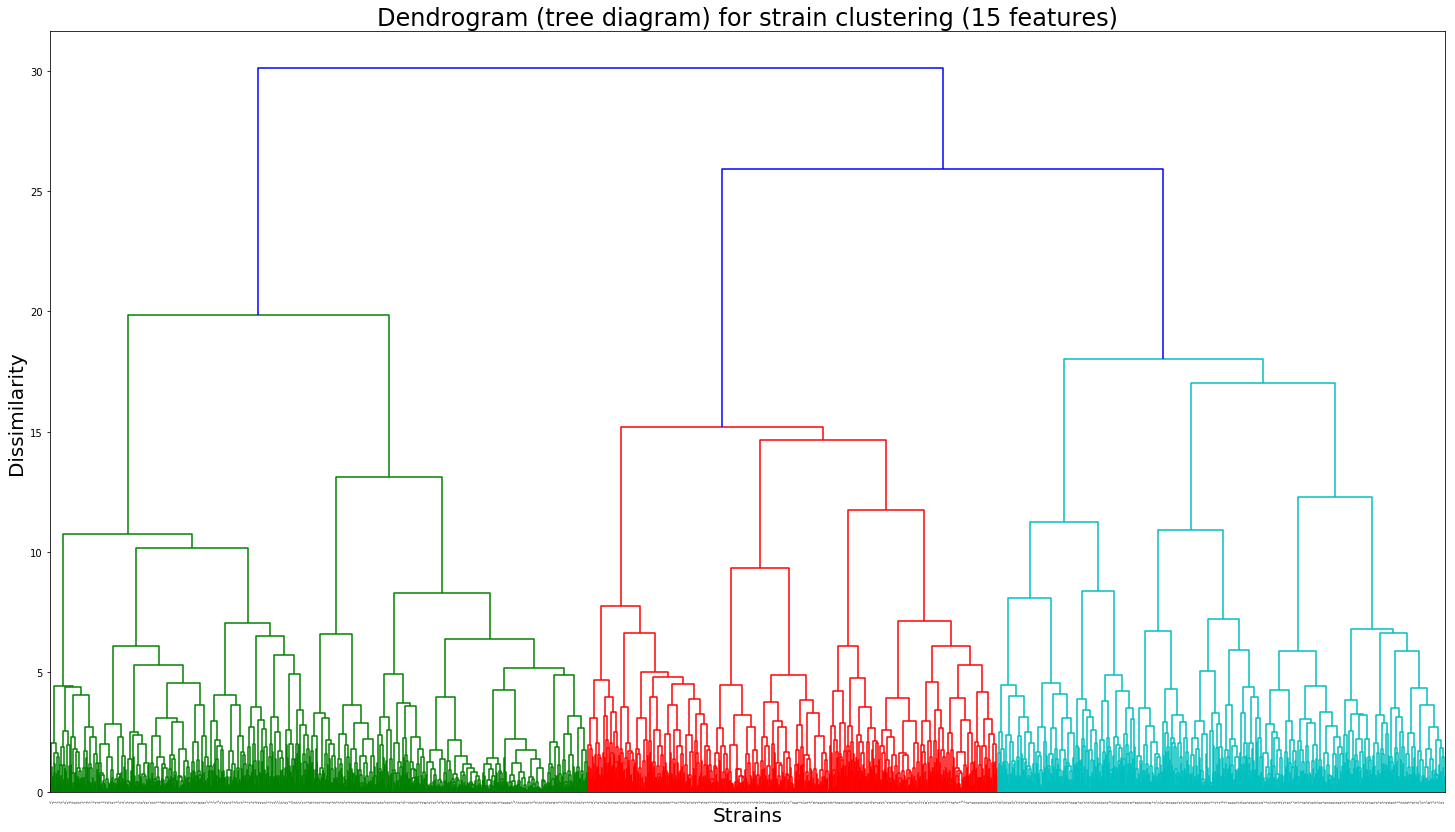

In [22]:
# Dendrogram for 15 features
X = df[useful_features_2.index]
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
dendrogram(linky, leaf_rotation=90, leaf_font_size=0) # full dendrogram
# dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
plt.title('Dendrogram (tree diagram) for strain clustering (15 features)', fontsize=24)
plt.xlabel('Strains', fontsize=20)
plt.ylabel('Dissimilarity', fontsize=20)
plt.show();

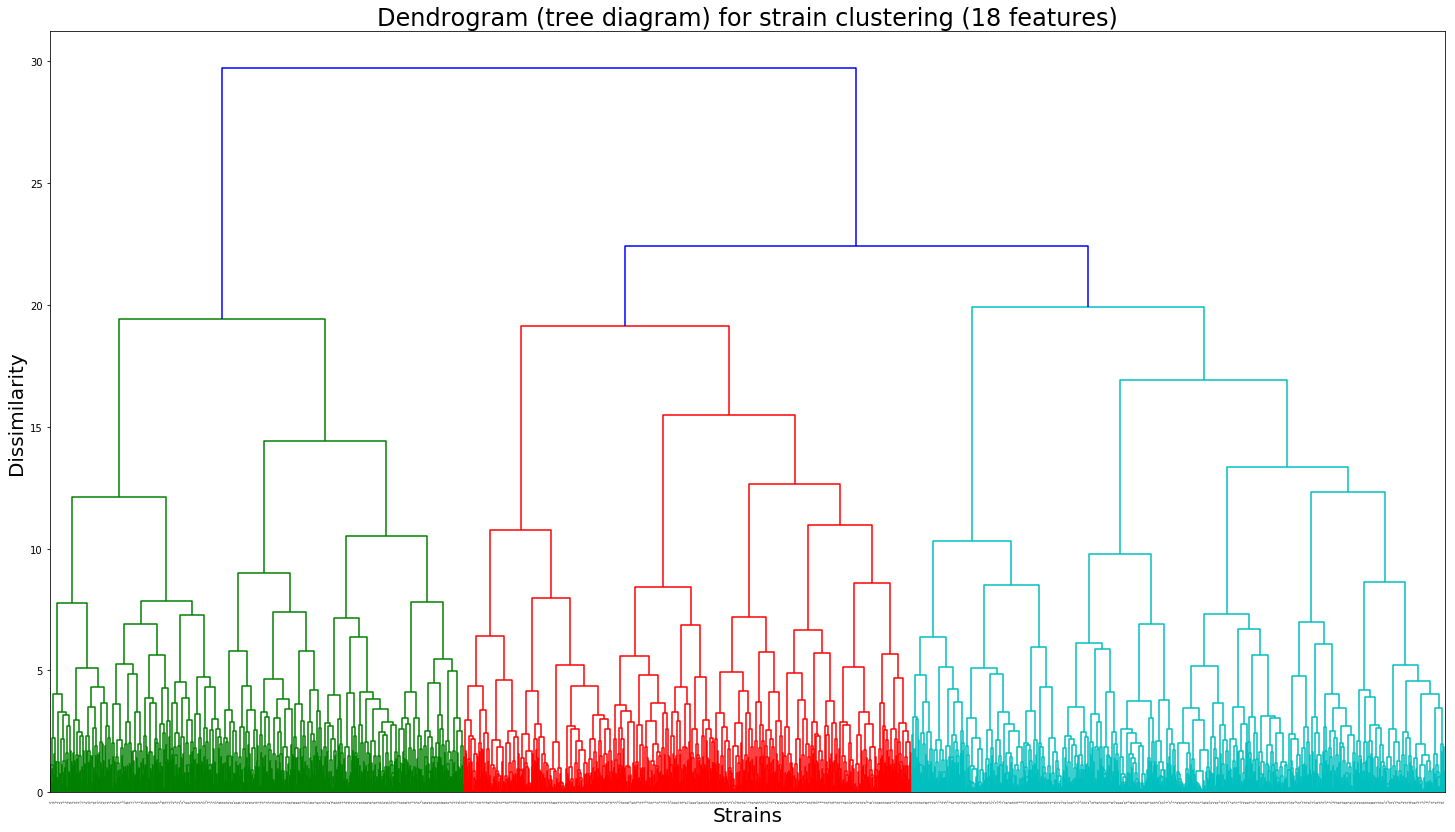

In [23]:
# Dendrogram for 18 features
X = df[useful_features_3.index]
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
dendrogram(linky, leaf_rotation=90, leaf_font_size=0) # full dendrogram
# dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
plt.title('Dendrogram (tree diagram) for strain clustering (18 features)', fontsize=24)
plt.xlabel('Strains', fontsize=20)
plt.ylabel('Dissimilarity', fontsize=20)
plt.show();

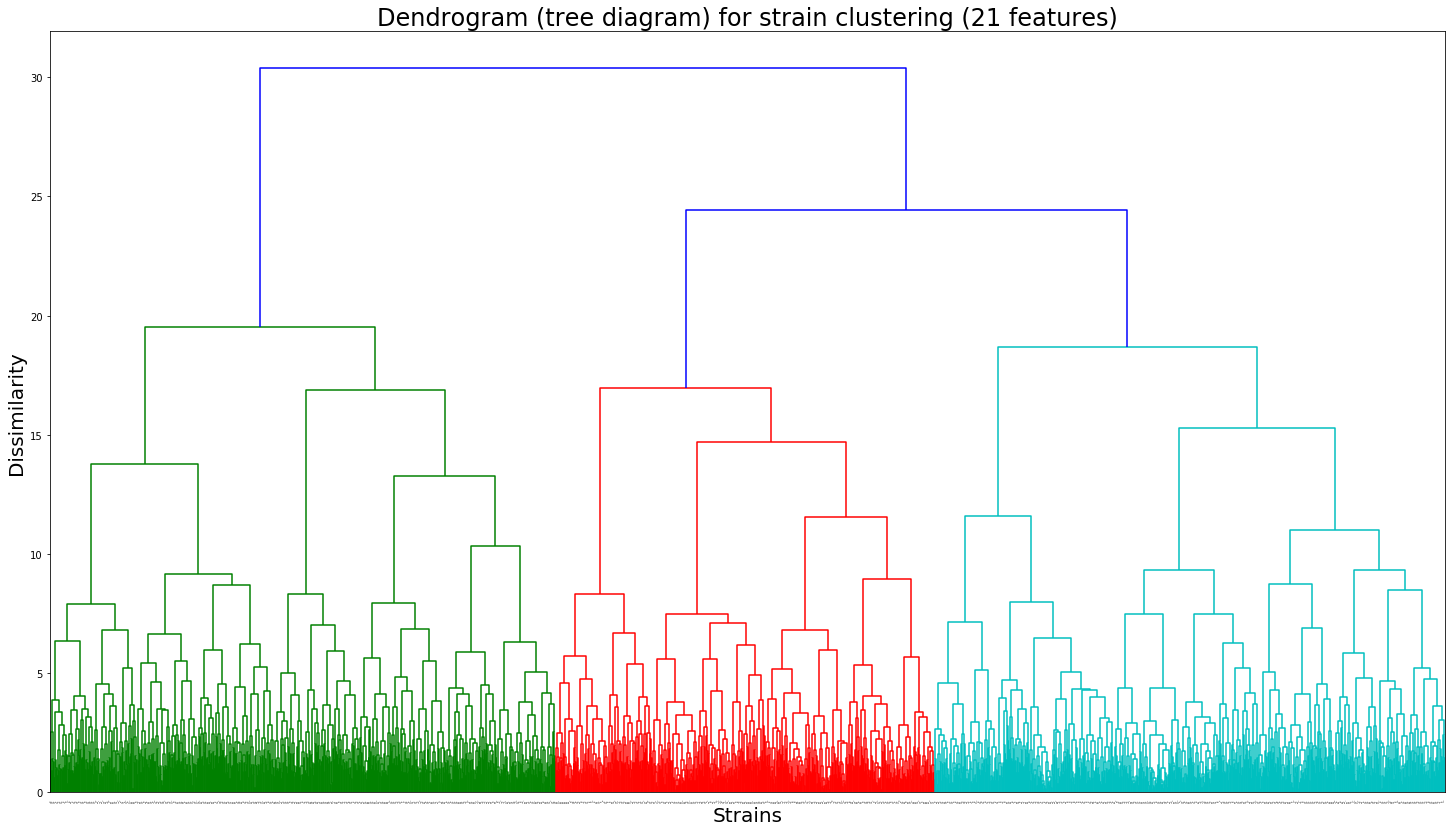

In [24]:
# Dendrogram for 21 features
X = df[useful_features_4.index]
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
dendrogram(linky, leaf_rotation=90, leaf_font_size=0) # full dendrogram
# dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
plt.title('Dendrogram (tree diagram) for strain clustering (21 features)', fontsize=24)
plt.xlabel('Strains', fontsize=20)
plt.ylabel('Dissimilarity', fontsize=20)
plt.show();

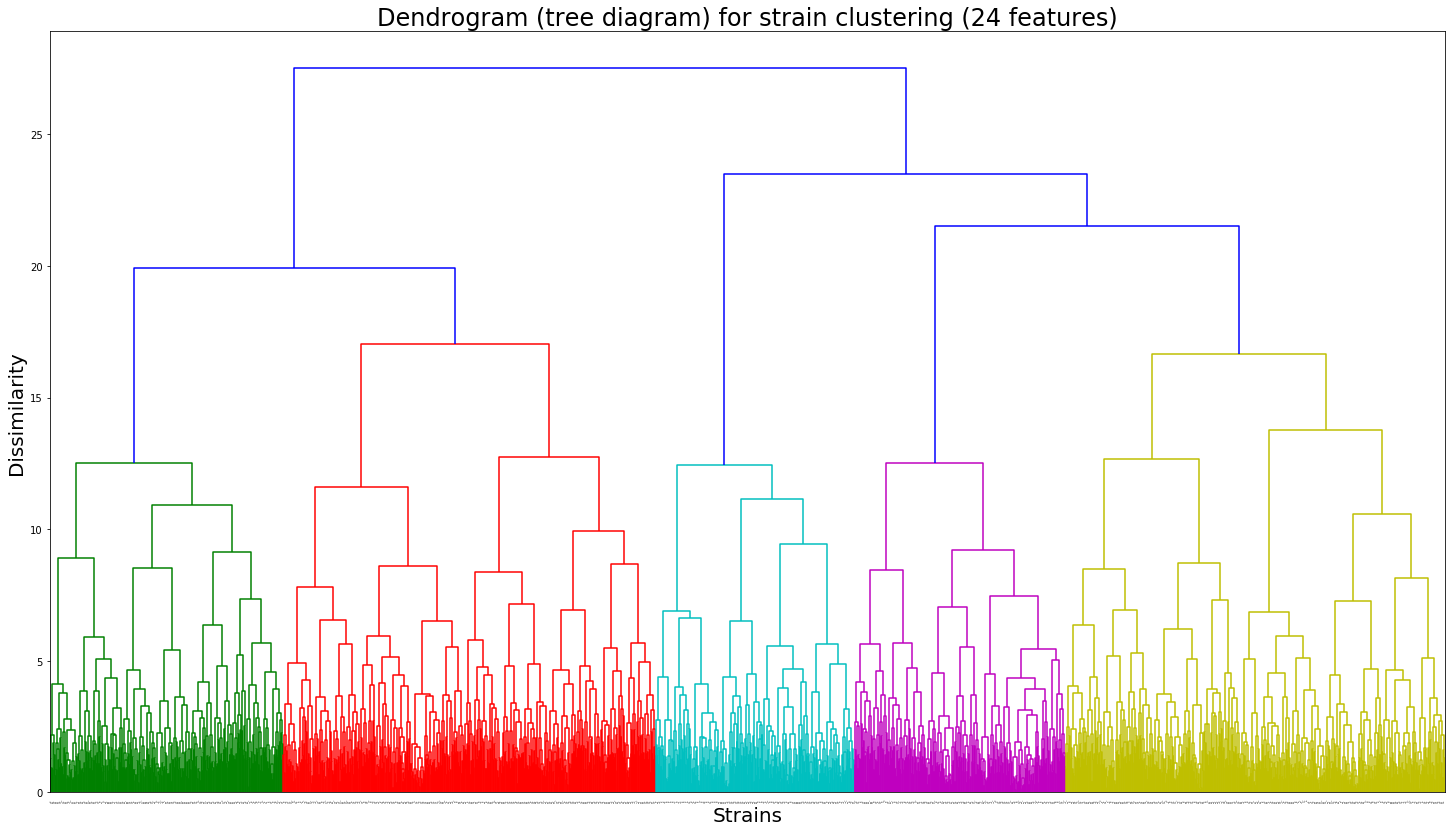

In [25]:
# Dendrogram for 24 features
X = df[useful_features_6.index]
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
dendrogram(linky, leaf_rotation=90, leaf_font_size=0) # full dendrogram
# dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
plt.title('Dendrogram (tree diagram) for strain clustering (24 features)', fontsize=24)
plt.xlabel('Strains', fontsize=20)
plt.ylabel('Dissimilarity', fontsize=20)
plt.show();

From these it looks like our first 15 features will give us the cleanest clustering. Let's use those for our best model.